In [41]:
using TrajectoryOptimization
using Plots
using MeshCat
using GeometryTypes
using CoordinateTransformations
using FileIO
using LinearAlgebra
using Pkg

In [67]:
### Solver options ###
opts = SolverOptions()
opts.verbose = true;
opts.square_root = true;
opts.penalty_max = 1.0e8;
#opts.outer_loop_update_type=:default;
opts.outer_loop_update_type=:momentum; #makes very little difference
#opts.outer_loop_update_type=:accelerated; #makes a big difference but seems to overshoot and oscillate (d0 a linesearch?)
opts.iterations = 500;
opts.constraint_tolerance_coarse = 1e-4;
opts.constraint_tolerance = 1e-4;

In [68]:
# Model
n = 13 # states (quadrotor w/ quaternions)
m = 4 # controls
model = Model(Dynamics.quadrotor_dynamics!,n,m)

TrajectoryOptimization.AbstractModel(TrajectoryOptimization.Dynamics.quadrotor_dynamics!, 13, 4)

In [69]:
# Objective and constraints
Qf = 100.0*Matrix{Float64}(I, n, n)
Q = (1.0)*Matrix{Float64}(I, n, n)
R = (0.1)*Matrix{Float64}(I, m, m)
tf = 5.0
dt = 0.05

# -initial state
x0 = zeros(n)
x0[4:7] = [1;0;0;0]

# -final state
xf = zeros(n)
xf[1:3] = [20.0;20.0;0.0] # xyz position
xf[4:7] = [1;0;0;0]
xf

# -control limits
u_min = -10.0
u_max = 10.0

# -obstacles
quad_radius = 3.0
sphere_radius = 1.0

n_spheres = 4
spheres = ([5.0;9.0;9.0;15.0;],[5.0;9.0;9.0;15.0],[0.0;0.0;4.0;0.0],[sphere_radius;sphere_radius;sphere_radius;sphere_radius])
function cI(x,u)
    [TrajectoryOptimization.sphere_constraint(x,spheres[1][1],spheres[2][1],spheres[3][1],spheres[4][1]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][2],spheres[2][2],spheres[3][2],spheres[4][2]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][3],spheres[2][3],spheres[3][3],spheres[4][3]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][4],spheres[2][4],spheres[3][4],spheres[4][4]+quad_radius);
     -x[3]]
end

# -constraint that quaternion should be unit
#function cE(x,u)
#    [x[4]^2 + x[5]^2 + x[6]^2 + x[7]^2 - 1.0]
#end

obj_uncon = LQRObjective(Q, R, Qf, tf, x0, xf);
obj_con = TrajectoryOptimization.ConstrainedObjective(obj_uncon, u_min=u_min, u_max=u_max);
#obj_con = TrajectoryOptimization.ConstrainedObjective(obj_uncon, u_min=u_min, u_max=u_max, cI=cI, cE = cE)

In [70]:
# Solver
solver_uncon = Solver(model,obj_uncon,integration=:rk3,dt=dt,opts=opts)
solver = Solver(model,obj_con,integration=:rk3,dt=dt,opts=opts)


# - Initial control and state trajectories
U = (0.5*9.8/4.0).*ones(solver.model.m, solver.N); #Stationary Hover
# X_interp = line_trajectory(solver)

In [ ]:
### Solve ###
results, stats = solve(solver,U);
#results, stats = solve(solver_uncon,U);

┌ Info: Solving Constrained Problem...
└ @ TrajectoryOptimization /Users/zacman/.julia/dev/TrajectoryOptimization/src/ilqr_methods.jl:267
┌ Info: Outer loop 1 (begin)
└ @ TrajectoryOptimization /Users/zacman/.julia/dev/TrajectoryOptimization/src/solve.jl:175
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    1     11099.599176  31351.4585              0.998449  0.5       10.00302  31302.83  0e+00     2.711799 1         Inf        0e+00    0          
    2     3157.0566334  7947.76264              0.999343  0.5       5.003836  7942.543  0e+00     4.988156 1         Inf        0e+00    0          
    3     753.21548663  2655.75339           

    26    541.80323329  14.2402269              0.112962  0.25      0.006232  1.608598  0e+00     0.120498 7         Inf        0e+00    0          
    27    536.57945191  13.4459227              0.388503  0.25      0.005605  5.223781  0e+00     0.122432 7         Inf        0e+00    0          
    28    535.19633637  9.39012364              0.147295  0.25      0.005     1.383116  0e+00     0.102583 7         Inf        0e+00    0          
    29    533.80152531  9.12307676              0.152888  0.25      0.004945  1.394811  0e+00     0.075618 7         Inf        0e+00    0          
    30    532.05994955  4.97473958              0.350084  0.125     0.00457   1.741576  0e+00     0.079436 7         Inf        0e+00    0          
    31    527.20560788  5.06018444              0.959321  0.25      0.003665  4.854342  0e+00     0.058951 7         Inf        0e+00    0          
    32    526.93628723  0.28869513              0.932889  0.03125   0.003602  0.269321  0e+00     0.043295

In [22]:
### Results ###
println("Final position: $(results.X[end][1:3])\n       desired: $(obj_uncon.xf[1:3])\n    Iterations: $(stats["iterations"])\n Max violation: $(max_violation(results))")

Final position: [19.9999, 19.9999, -9.90088e-5]
       desired: [20.0, 20.0, 0.0]
    Iterations: 100
 Max violation: 0.0014047802779476593


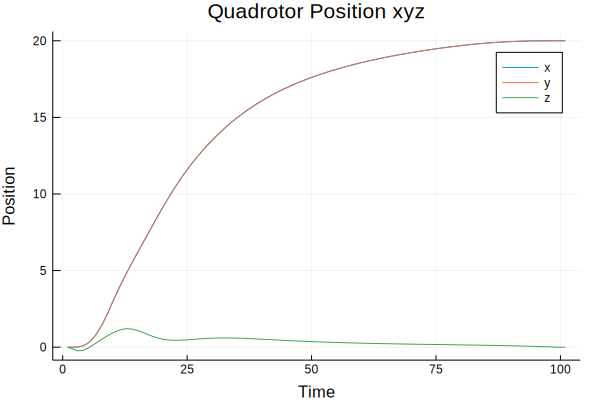

In [23]:
# Position
xhist = hcat(results.X...)
plot(xhist[1:3,:]',title="Quadrotor Position xyz",xlabel="Time",ylabel="Position",label=["x";"y";"z"])

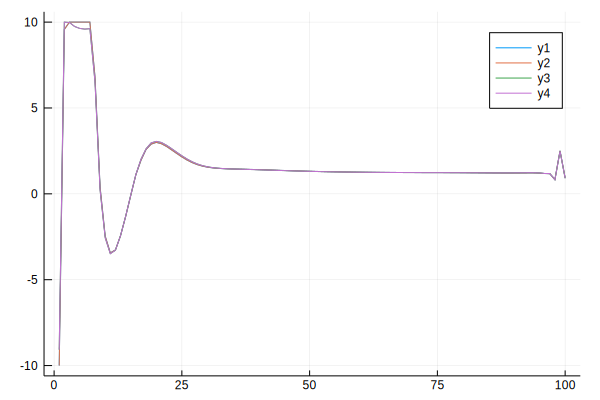

In [24]:
# Control
uhist = hcat(results.U...)
plot(uhist')

Quaternion Animation

In [ ]:
### Visualizer using MeshCat and GeometryTypes ###
# Set up visualizer
vis = Visualizer()
open(vis)

# Import quadrotor obj file
urdf_folder = joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf")
# urdf = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor.urdf")
obj = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor_base.obj")

# color options
green = MeshPhongMaterial(color=RGBA(0, 1, 0, 1.0))
red = MeshPhongMaterial(color=RGBA(1, 0, 0, 1.0))
blue = MeshPhongMaterial(color=RGBA(0, 0, 1, 1.0))
orange = MeshPhongMaterial(color=RGBA(233/255, 164/255, 16/255, 1.0))
black = MeshPhongMaterial(color=RGBA(0, 0, 0, 1.0))
black_transparent = MeshPhongMaterial(color=RGBA(0, 0, 0, 0.1))

# geometries
robot_obj = load(obj)
sphere_small = HyperSphere(Point3f0(0), convert(Float32,0.03*quad_radius)) # trajectory points
sphere_medium = HyperSphere(Point3f0(0), convert(Float32,quad_radius))

#obstacles = vis["obs"]
traj = vis["traj"]
target = vis["target"]
robot = vis["robot"]

# Set camera location
settransform!(vis["/Cameras/default"], compose(Translation(25., -5., 10),LinearMap(RotZ(-pi/4))))

# Create and place obstacles
#for i = 1:n_spheres
#    setobject!(vis["obs"]["s$i"],HyperSphere(Point3f0(0), convert(Float32,spheres[4][i])),red)
#    settransform!(vis["obs"]["s$i"], Translation(spheres[1][i], spheres[2][i], spheres[3][i]))
#end

# Create and place trajectory
for i = 1:solver.N
    setobject!(vis["traj"]["t$i"],sphere_small,blue)
    settransform!(vis["traj"]["t$i"], Translation(xhist[1,i], xhist[2,i], xhist[3,i]))
end

In [ ]:
# Create and place initial position
setobject!(vis["robot"]["ball"],sphere_medium,black_transparent)
setobject!(vis["robot"]["quad"],robot_obj,black)
settransform!(vis["robot"],compose(Translation(xhist[1,1], xhist[2,1], xhist[3,1]),LinearMap(TrajectoryOptimization.quat2rot(xhist[4:7,1]))))

In [ ]:
# Animate quadrotor
for i = 1:solver.N
    settransform!(vis["robot"], compose(Translation(xhist[1,i], xhist[2,i], xhist[3,i]),LinearMap(TrajectoryOptimization.quat2rot(xhist[4:7,i]))))
    sleep(solver.dt)
end

# # -unconstrained version
# for i = 1:solver.N
#     settransform!(vis["robot"], compose(Translation(results_uncon.X[1,i], results_uncon_euler.X[2,i], results_uncon.X[3,i]),LinearMap(TrajectoryOptimization.quat2rot(results_uncon.X[4:7,i]))))
#     sleep(solver.dt*2)
# end
